# 3. Statistical Power

In [1]:
using Distributions
using DataFrames
using CSV, HTTP # Get data from web
using GLM
using Plots, Measures, StatsPlots
using Printf

# Default plot settings
gr(html_output_format=:png); # Avoid SVG and forcing PNG format for plots

**Utility functions**
Some of these may have an efficient implementation in other packages, but for keeping
things simple and complete, a crude implementation is given here.

In [2]:
# scale() function of R
scale_data(d::AbstractArray) = (d .- mean(d, dims=1)) ./ std(d, dims=1)

scale_data (generic function with 1 method)

## 3.1 Test statistic under the alternative

##### Example 3.1

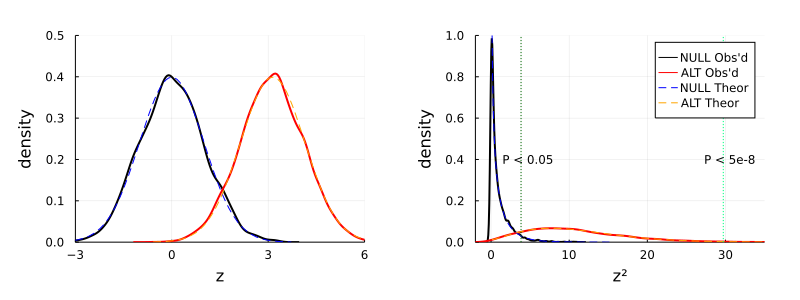

In [3]:
n = 500 # individuals
p = 5000 # SNPs for both null and alternative
f = 0.50 # MAF
b_alt = 0.20 # effect size under the alternative hypothesis
x = rand(Binomial(2, f), n) # genotypes at 1 SNP for n individuals
y = scale_data(randn(n)) # random phenotype normalized to have SD = 1
se = stderror(lm(@formula(y ~ x), DataFrame("x"=>x, "y"=>y, copycols=false)))[2] # pick se
b_hat_null = se * randn(p) # estimate under null
b_hat_alt = b_alt .+ se * randn(p) # estiamtes under alternatives

fig = plot(layout=(1, 2), size=(800, 300), margin=7mm)

plot!(fig, subplot=1, xaxis=("z", (-3, 6)), yaxis=("density", (0, 0.5))) # Empty panel for plotting
# draw observed densities of z-scores
density!(b_hat_null/se, lc=:black, lw=2, label=nothing) # Wald stat for null variants
density!(b_hat_alt/se, lc=:red, lw=2, label=nothing) # Wald stat for alternate variants
# Let's add theoretical densities
plot!(Normal(0, 1), lc=:blue, ls=:dash, label=nothing) # for null
plot!(Normal(b_alt/se, 1), lc=:orange, ls=:dash, label=nothing) # for alternative

plot!(fig, subplot=2, xaxis=("z²", (-2, 35)), yaxis=("density", (0, 1))) # Empty panel for plotting
density!(subplot=2, (b_hat_null/se).^2, lc=:black, lw=2, label="NULL Obs'd")
density!(subplot=2, (b_hat_alt/se).^2, lc=:red, lw=2, label="ALT Obs'd")
plot!(subplot=2, Chisq(1), lc=:blue, ls=:dash, label="NULL Theor")
plot!(subplot=2, NoncentralChisq(1, (b_alt/se)^2), lc=:orange, ls=:dash, label="ALT Theor") # NCP = (beta/se)^2
# Let's add significance threholds corresponding to 0.05 and 5e-8
# By definition, the thresholds are always computed under the null
q_thresh = quantile(Chisq(1), 1 .- [0.05, 5e-8]) # For upper quantile, substract from 1.0
vline!(subplot=2, q_thresh', ls=:dot,  lc=[:darkgreen :springgreen], label=nothing)
annotate!(subplot=2,
    (q_thresh[1] + 4, 0.40, text("P < 0.05", :right, 8)),
    (q_thresh[2] + 4, 0.40, text("P < 5e-8", :right, 8))
)

In [4]:
q_thresh = quantile(Chisq(1), 1.0 .- [0.05, 5e-8]) # repeating the threholds in chi-sq
ccdf(NoncentralChisq(1, (b_alt/se)^2), q_thresh) # Correspond to the right tail probabilties

2-element Vector{Float64}:
 0.8809321146743954
 0.01039743973416675

## 3.2 Ingedients of power

##### Example 3.2

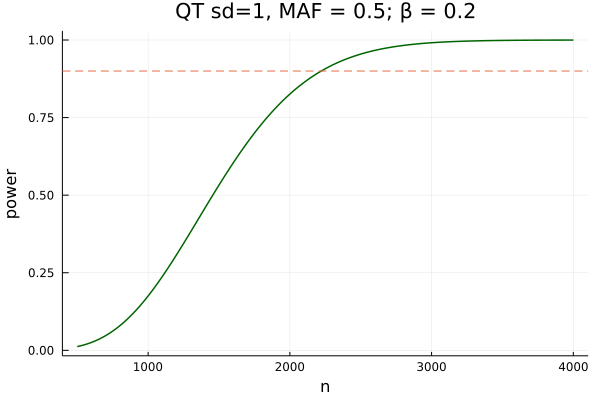

In [5]:
f = 0.50
b_alt = 0.20
σ = √(1 - 2*f*(1-f)*b_alt^2) # error sd after SNP effect is accounted for
ns = range(500, 4000, step=10)
# candidate values for n
ses = σ ./ .√(ns * 2 * f * (1-f)) # SEs corresponding to each candidate n
q_thresh = quantile(Chisq(1), 1-5e-8) # chi-sqr threhold corresp alpha=5e-8
pwr = [ccdf(NoncentralChisq(1, (b_alt/s)^2), q_thresh) for s ∈ ses] # power at alpha=5e-8 for VECTOR of SE values
plot(ns, pwr, lc=:darkgreen, xlabel="n", ylabel="power", lw=1.5, label=nothing,
    title=@sprintf("QT sd=1, MAF = %.1f; β = %.1f", f, b_alt),
    html_output_format=:png
)
hline!([0.90], ls=:dash, label=nothing)

In [6]:
ns[findfirst(>=(0.90), pwr)]

2230

In [7]:
2 * f * (1-f) * b_alt^2

0.020000000000000004

##### Example 3.3

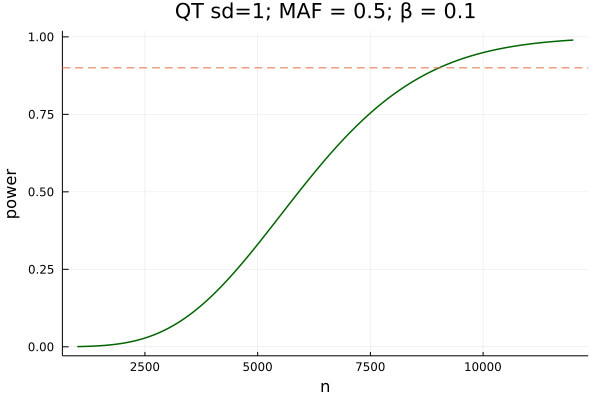

In [8]:
f = 0.5
y_explained = 0.005
b_alt = √(y_explained / (2*f*(1-f))) # this is beta that explains 0.5%
σ = √(1 - y_explained) # error sd after SNP effect is accounted for
ns = range(1000, 12000, step=10) # candidate n
ses = σ ./ .√(ns*2*f*(1-f)) # SE corresponding to each n
q_thresh = quantile(Chisq(1), 1-5e-8) # threhold corresponding to alpha = 5e-8
pwr = [ccdf(NoncentralChisq(1, (b_alt/s)^2), q_thresh) for s ∈ ses]
plot(ns, pwr, lc=:darkgreen, xlabel="n", ylabel="power", lw=1.5, label=nothing,
    title=@sprintf("QT sd=1; MAF = %.1f; β = %.1f", f, b_alt)
)
hline!([0.90], ls=:dash, label=nothing)

In [9]:
ns[findfirst(>=(0.90), pwr)]

9030

##### Example 3.6

In [10]:
n = [500000, 60000]
ϕ = [15000, 30000] ./ n
DataFrame("n" => n, "ϕ" => ϕ, "eff_n" => @. n * ϕ * (1 - ϕ))

,n,ϕ,eff_n
,Int64,Float64,Float64
1,500000,0.03,14550.0
2,60000,0.5,15000.0


##### Example 3.7

In [11]:
b = log(1.1) # b is log-odds, approximately GRR for a low prevalance disease
n = 20000
f = 0.4
ϕ = 0.5
ccdf(NoncentralChisq(1, 2*f*(1-f)*n*ϕ*(1-ϕ)*b^2), quantile(Chisq(1), 1-5e-8))

0.21708252186482652

## 3.3. Why well powered studies are so important?

In [12]:
ENV["COLUMNS"]=200 # To display all columns in data
data_url = "http://www.mv.helsinki.fi/home/mjxpirin/GWAS_course/material/sz_res.txt"
sz_res = CSV.File(HTTP.get(data_url).body) |> DataFrame
# Because the file has a trailing whitespace for each line, the dataframe
# has one extra column with all missing values.
select!(sz_res, Not(size(sz_res, 2)))

,Index_SNP,A12,Frq_case,Frq_control,Chr,Start_Position,End_Position,Combined_OR,Combined_95lower,Combined_95upper,Combined_P,Discovery_OR,Discovery_P,Replication_OR,Replication_P
,String,String,Float64,Float64,String,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,rs4648845,TC,0.533,0.527,1,2372401,2402501,1.072,1.049,1.097,8.7e-10,1.071,4.03e-9,1.088,0.0885
2,chr1_8424984_D,I2D,0.319,0.301,1,8411184,8638984,1.071,1.048,1.095,1.17e-9,1.071,2.03e-9,1.057,0.296
3,rs1498232,TC,0.311,0.296,1,30412551,30437271,1.069,1.046,1.093,2.86e-9,1.072,1.28e-9,0.999,0.988
4,rs11210892,AG,0.659,0.677,1,44029384,44128084,0.934,0.914,0.954,3.39e-10,0.933,4.97e-10,0.949,0.308
5,rs12129573,AC,0.377,0.358,1,73766426,73991366,1.078,1.056,1.101,2.03e-12,1.072,2.35e-10,1.217,6.25e-5
6,rs76869799,CG,0.959,0.964,1,97792625,97834525,0.846,0.798,0.897,2.64e-8,0.85,1.44e-7,0.779,0.0534
7,rs1702294,TC,0.175,0.191,1,98374984,98559084,0.887,0.865,0.911,3.36e-19,0.891,2.79e-17,0.831,0.00135
8,rs140505938,TC,0.151,0.164,1,149998890,150242490,0.914,0.888,0.94,4.49e-10,0.913,9.34e-10,0.928,0.253
9,rs6670165,TC,0.196,0.184,1,177247821,177300821,1.075,1.047,1.103,4.45e-8,1.074,1.16e-7,1.09,0.146


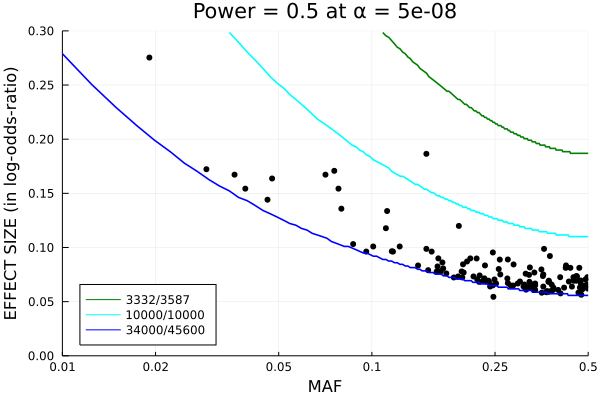

In [13]:
# Let's plot the known SZ variants on frequency - effect size coordinates
# And draw some power curves there at genome wide significance threhold

maf = sz_res[:, :Frq_control]  # Not yet MAF but allel 1 frequency, create a copy!
@. maf[maf > 0.5] = 1 - maf[maf > 0.5] # Make it MAF, always less than 0.5
b = abs.(log.(sz_res[!, :Combined_OR])) # effect size on log-odds-ratio scale with positive sign
pw_thresh = 0.5
p_threshold = 5e-8
scatter(maf, b, color=:black, label=nothing)

q = quantile(Chisq(1), 1 - p_threshold) # Chi-square value corresponding significance threhold
Ns = [3332 3587; 10000 10000; 34000 45600]
cols = [:green, :cyan, :blue]

f = range(0.01, 0.50, length=200)
b = range(0, 0.3, length=200)
for (j, set) in enumerate(eachrow(Ns))
    pw = Vector{Float64}(undef, length(b)) # power at each candidate b
    b_for_f = Vector{}(undef, length(f)) # for each f gives the b values that leads to the target power
    for i ∈ 1:length(f)
        pw = [ccdf(NoncentralChisq(1, set[1]*set[2] / sum(set) * 2 * f[i] * (1-f[i]) * _b^2), q) for _b ∈ b]
        idx = findfirst(>=(pw_thresh), pw)
        b_for_f[i] = isnothing(idx) ? missing : b[idx]
    end
    plot!(f, b_for_f, lc=cols[j], lw=1.6, label=join(set, "/"))
end

plot!(xaxis=("MAF", (0.01, 0.50), :log10, 
        ([0.01, 0.02, 0.05, 0.10, 0.25, 0.50], [0.01, 0.02, 0.05, 0.10, 0.25, 0.50])),
    yaxis=("EFFECT SIZE (in log-odds-ratio)", (0.0, 0.30), 0.00:0.05:0.30),
    title=@sprintf("Power = %.1f at α = %1.e", pw_thresh, p_threshold),
    legend=:bottomleft
)